In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

In [2]:
#Importing data
house = pd.read_csv("data/kc_house_data.csv")
house

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,...,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,...,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,...,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,0.0,...,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


In [3]:
#Checking for nulls
print(house.isna().sum())

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64


In [4]:
#big data cleaning section

#sqft_basement had some invalid values. banished.
house = house.replace('?', np.nan)

#nulls banished, replaced with 0 after checking the dataset for appropriateness
house.fillna(0, inplace=True)

#duplicates banished
house = house.drop_duplicates()

#dropping irrelevant data
house = house.drop(['zipcode', 'lat', 'long', 'date', 'id'], axis=1)

#defining columns to be converted into specific data types
#almost everything is being converted into integers, since they are whole numbers
int_cols = ['price', 'bedrooms', 'sqft_living', 'sqft_lot', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15', 'waterfront', 'view']
#I don't know how it's possible to have a quarter of a bathroom,
#but it's in the dataset so these two have to be floats
float_cols = ['bathrooms', 'floors']

#converting the columns to integers, had to convert them to floats as an intermediary step to avoid errors
house[int_cols] = house[int_cols].astype(float)
house[int_cols] = house[int_cols].astype(int)

#converting the columns to floats
house[float_cols] = house[float_cols].astype(float)

house

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
0,221900,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,1340,5650
1,538000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,1690,7639
2,180000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,2720,8062
3,604000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,1360,5000
4,510000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,1530,1509
21593,400000,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,1830,7200
21594,402101,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,1020,2007
21595,400000,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,1410,1287


In [5]:
#Checking conversions
house.dtypes

price              int64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [6]:
#Sorting the year the house was built into decades
#I thought this might affect the results somehow.
#It didn't, but the code is neat, so it stays
house["decade_built"] = (house["yr_built"] // 10) * 10
house["decade_built"] = house["decade_built"].astype(int)

In [7]:
#making a dummy value showing if a house has been renovated at all,
#vs being renovated before 2000 and post 2000
#I wanted to see if a relatively recent renovation affected price
house['yr_renovated_dummy'] = pd.cut(house['yr_renovated'], bins=[-1, 0, 1999, float('inf')], labels=[0, 1, 2]).astype(int)

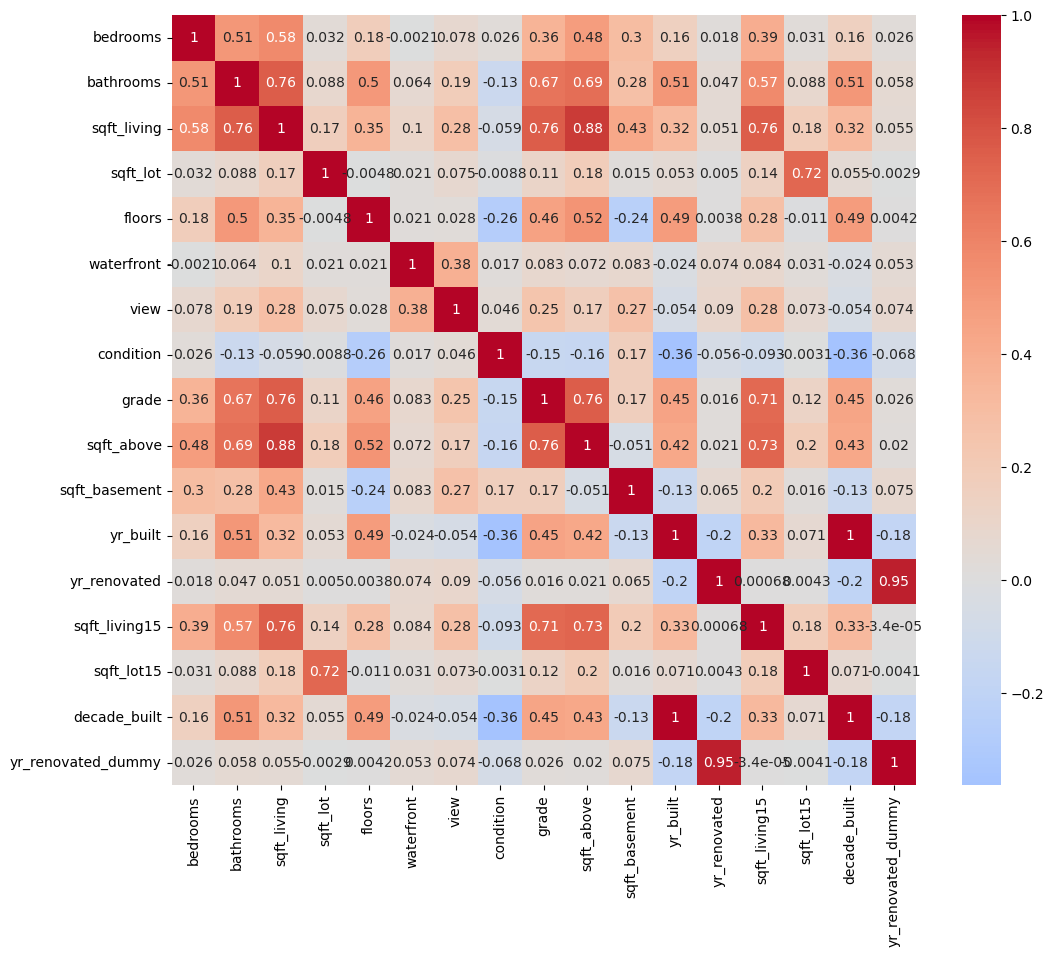

In [8]:
#Making a heatmap to look for highly colinear values

# Generate correlation matrix
corr_matrix = house.drop("price", axis=1).corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.show()

In [9]:
#That made my eyes bleed and I can't be bothered to look at each individual value so instead I spent hours searching
#for a way to display only the highly colinear values.
#I consider this an efficient use of my time

# Selecting the price column and calculating correlations with other columns
features = []
correlations = []
corr = house.corr()
for idx, correlation in corr['price'].iteritems():
    if correlation >= 0.3 and idx != 'price':
        features.append(idx)
        correlations.append(correlation)
corr_price_df = pd.DataFrame({'Features': features, 'Correlations': correlations})

# Checking for multicollinearity among the selected features
multicollinear_features = []
multicollinear_corr = []
def check_multicollinearity(feature):
    for idx, correlation in corr[feature].iteritems():
        if correlation >= 0.8 and idx != feature:
            multicollinear_features.append([feature, idx])
            multicollinear_corr.append(correlation)

for feature in corr:
    check_multicollinearity(feature)
mc_df = pd.DataFrame({'Features': [f[0] for f in multicollinear_features],
                      'Multicollinear_Features': [f[1] for f in multicollinear_features],
                      'Correlations': multicollinear_corr})

# Displaying the results
print('Features with Correlations to Price')
display(corr_price_df)

print('Multicollinear Features')
display(mc_df)

Features with Correlations to Price


,Features,Correlations
0,bedrooms,0.308787
1,bathrooms,0.525906
2,sqft_living,0.701917
3,view,0.393497
4,grade,0.667951
5,sqft_above,0.605368
6,sqft_basement,0.321108
7,sqft_living15,0.585241


Multicollinear Features


,Features,Multicollinear_Features,Correlations
0,sqft_living,sqft_above,0.876448
1,sqft_above,sqft_living,0.876448
2,yr_built,decade_built,0.995210
3,yr_renovated,yr_renovated_dummy,0.949577
4,decade_built,yr_built,0.995210
5,yr_renovated_dummy,yr_renovated,0.949577


In [10]:
#predictors["Features"] is my shortcut from here on to grab my variables without writing them out each time
#Dropping sqft_above due to multiccolinearity, dropping basement because all the 0 values kept causing
#the fragile stack of cards that is my code to break
predictors = corr_price_df.drop(5).drop(6)

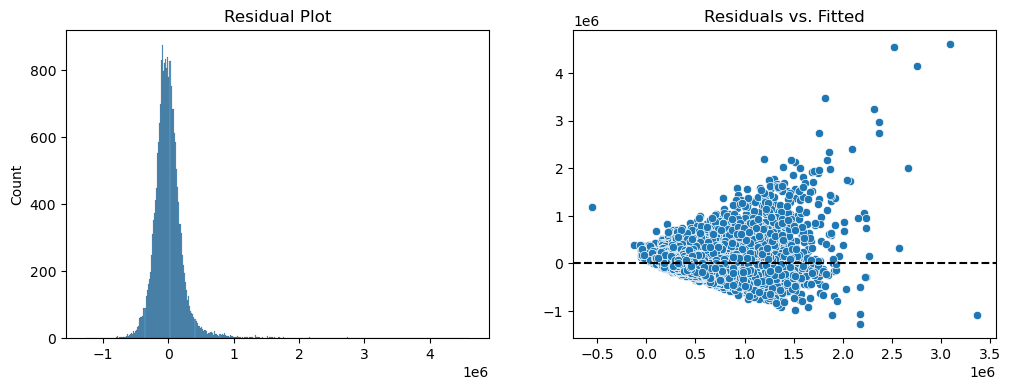

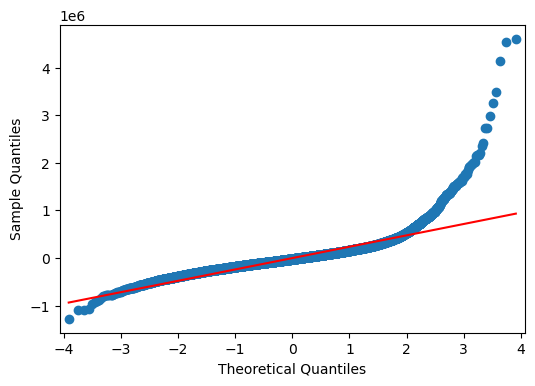

In [11]:
#Normality and homoscedacity check
# Fit simple linear regression model
model = smf.ols('price ~ ' + ' + '.join(predictors['Features']), data=house).fit()

#Residual plot
resid = model.resid
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
sns.histplot(resid, ax=ax1)
ax1.set_title('Residual Plot')
#Scatter Plot
sns.scatterplot(x=model.predict(), y=resid, ax=ax2)
ax2.axhline(0, color='k', linestyle='--')
ax2.set_title('Residuals vs. Fitted')
plt.show()
#QQ plot
fig, ax = plt.subplots(figsize=(6,4))
sm.qqplot(resid, line='s', ax=ax)
plt.show()

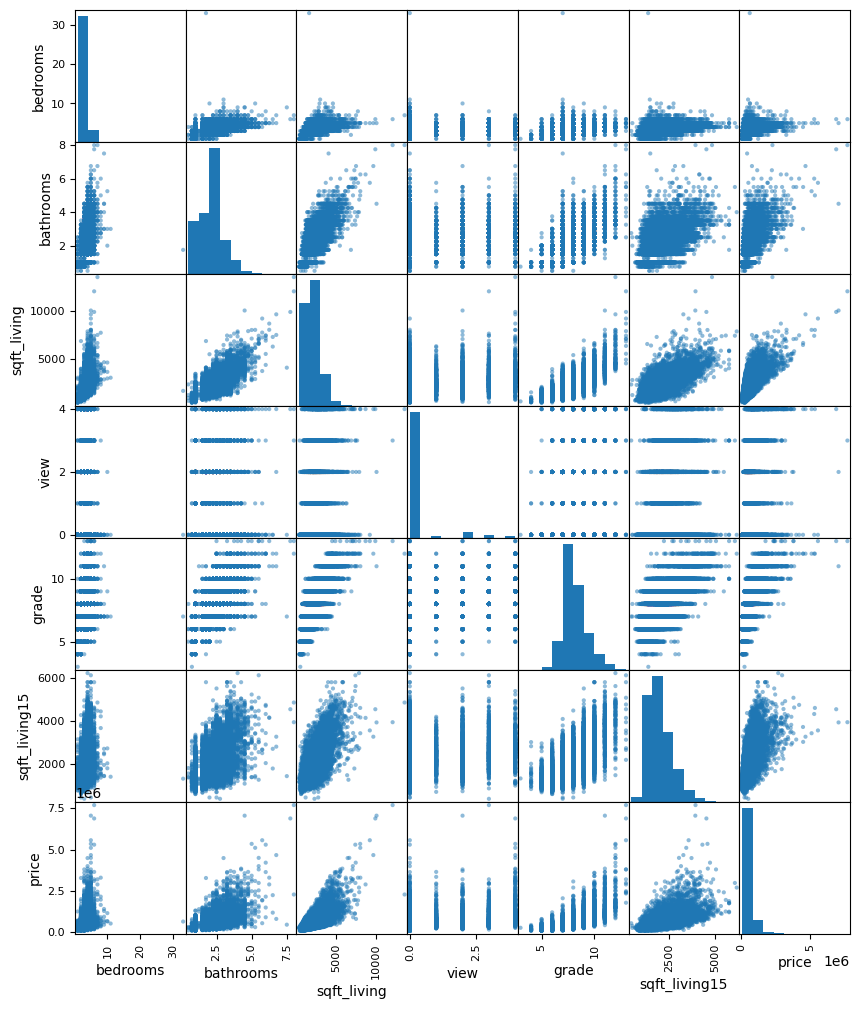

In [12]:
#Normal check of relevant features

x_cols = list(predictors['Features']) + ['price']
pd.plotting.scatter_matrix(house[x_cols], figsize=(10, 12))
plt.show()

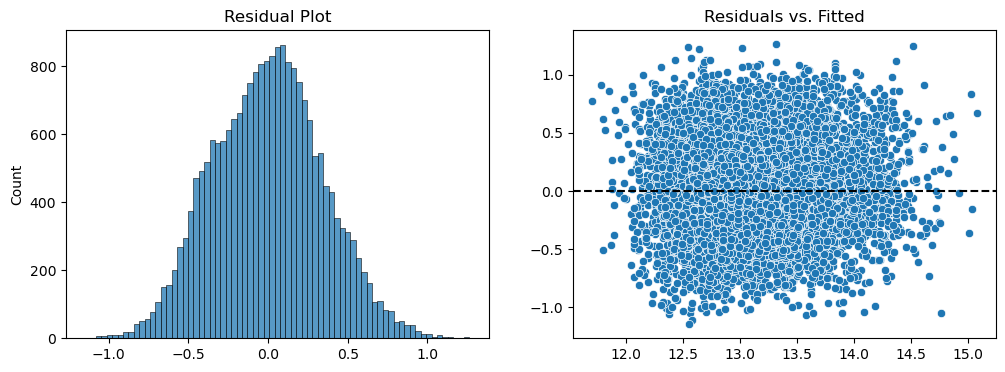

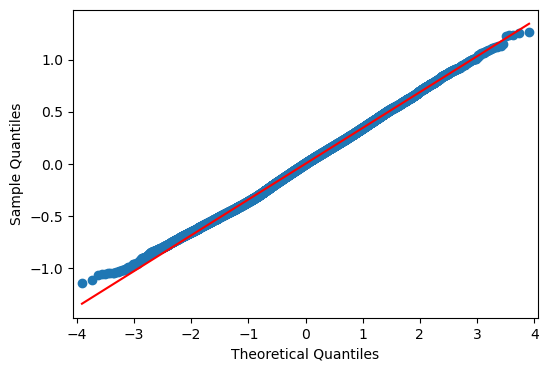

In [13]:
#Log adjustment

non_normal = ['price', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_above', 'sqft_lot15']
house_adjusted = house.copy()

for feat in non_normal:
    house_adjusted[feat] = np.where(house[feat] > 0, np.log(house[feat]), 0)
    house_adjusted[feat].replace(np.nan, 0, inplace=True)

#Normality and homoscedacity check part 2
# Fit simple linear regression model
model = smf.ols('price ~ ' + ' + '.join(predictors['Features']), data=house_adjusted).fit()

#Resisual plot
resid = model.resid
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
sns.histplot(resid, ax=ax1)
ax1.set_title('Residual Plot')
#Scatter Plot
sns.scatterplot(x=model.predict(), y=resid, ax=ax2)
ax2.axhline(0, color='k', linestyle='--')
ax2.set_title('Residuals vs. Fitted')
plt.show()
#QQ plot
fig, ax = plt.subplots(figsize=(6,4))
sm.qqplot(resid, line='s', ax=ax)
plt.show()

In [14]:
#Take 2

# Selecting the price column and calculating correlations with other columns
features = []
correlations = []
corr = house_adjusted.corr()
for idx, correlation in corr['price'].iteritems():
    if correlation >= 0.3 and idx != 'price':
        features.append(idx)
        correlations.append(correlation)
corr_price_df = pd.DataFrame({'Features': features, 'Correlations': correlations})

# Checking for multicollinearity among the selected features
multicollinear_features = []
multicollinear_corr = []
def check_multicollinearity(feature):
    for idx, correlation in corr[feature].iteritems():
        if correlation >= 0.8 and idx != feature:
            multicollinear_features.append([feature, idx])
            multicollinear_corr.append(correlation)

for feature in corr:
    check_multicollinearity(feature)
mc_df = pd.DataFrame({'Features': [f[0] for f in multicollinear_features],
                      'Multicollinear_Features': [f[1] for f in multicollinear_features],
                      'Correlations': multicollinear_corr})

# Displaying the results
print('Features with Correlations to Price')
display(corr_price_df)

print('Multicollinear Features')
display(mc_df)

Features with Correlations to Price


,Features,Correlations
0,bedrooms,0.343360
1,bathrooms,0.551249
2,sqft_living,0.674802
3,floors,0.310630
4,view,0.344653
5,grade,0.703720
6,sqft_above,0.586013
7,sqft_basement,0.313119
8,sqft_living15,0.607154


Multicollinear Features


,Features,Multicollinear_Features,Correlations
0,sqft_living,sqft_above,0.864979
1,sqft_lot,sqft_lot15,0.918665
2,sqft_above,sqft_living,0.864979
3,yr_built,decade_built,0.995210
4,yr_renovated,yr_renovated_dummy,0.949577
5,sqft_lot15,sqft_lot,0.918665
6,decade_built,yr_built,0.995210
7,yr_renovated_dummy,yr_renovated,0.949577


In [15]:
#Second verse, same as the first
predictors = corr_price_df.drop(6).drop(7)

In [16]:
#This section defines several functions to help me find outliers and remove them

#Defining a function to find outliers

def find_outliers(df, k=3):
    """
    Returns a dictionary where the keys are column names and the values are the number
    of outliers in each column. Outliers are defined as values that are more than k
    standard deviations from the mean, ignoring 0 values.
    """
    # Replace 0 values with NaN
    df_no_zeros = df.replace(0, np.nan)
    
    # Calculate the mean and standard deviation for each column, ignoring NaN values
    means = df_no_zeros.mean(skipna=True)
    stds = df_no_zeros.std(skipna=True)
    
    # Calculate the lower and upper bounds for outliers for each column
    lower_bound = means - k * stds
    upper_bound = means + k * stds
    
    # Find any values in the DataFrame that fall outside the bounds for each column
    outliers = (df < lower_bound) | (df > upper_bound)
    
    # Count the number of outliers for each column
    outlier_counts = outliers.sum()
    
    # Convert the Series to a dictionary and return it
    return outlier_counts.to_dict()

#Defining a second function to display outliers in a specific column

def find_column_outliers(df, column_name, k=3):
    """
    Prints information about the specified column in the given DataFrame. The output
    includes the mean, standard deviation, list of outliers, and number of outliers.
    Outliers are defined as values that are more than k standard deviations from the
    mean, ignoring 0 values.
    """
    # Replace 0 values with NaN in the specified column
    column_no_zeros = df[column_name].replace(0, np.nan)
    
    # Calculate the mean and standard deviation for the column, ignoring NaN values
    mean = column_no_zeros.mean(skipna=True)
    std = column_no_zeros.std(skipna=True)
    
    # Calculate the lower and upper bounds for outliers
    lower_bound = mean - k * std
    upper_bound = mean + k * std
    
    # Find any values in the column that fall outside the bounds
    outliers = (df[column_name] < lower_bound) | (df[column_name] > upper_bound)
    
    # Print information about the column
    print(f"{column_name} data for k={k}")
    print(f"Mean: {mean:.2f}")
    print(f"Standard deviation: {std:.2f}")
    print("Outliers:", df[column_name][outliers].tolist())
    print("Outlier count:", outliers.sum())


#Defining a function to drop outliers

def drop_column_outliers(df, column_name, k=3):
    """
    Drops rows from the given DataFrame where the value in the specified column
    is more than k standard deviations from the mean, ignoring 0 values.
    Returns the filtered DataFrame and prints the number of rows dropped.
    """
    # Replace 0 values with NaN in the specified column
    column_no_zeros = df[column_name].replace(0, np.nan)
    
    # Calculate the mean and standard deviation for the column, ignoring NaN values
    mean = column_no_zeros.mean(skipna=True)
    std = column_no_zeros.std(skipna=True)
    
    # Calculate the lower and upper bounds for outliers
    lower_bound = mean - k * std
    upper_bound = mean + k * std
    
    # Drop rows where the value in the specified column is more than k standard deviations from the mean
    df_filtered = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    
    # Calculate the number of rows dropped
    num_dropped = len(df) - len(df_filtered)
    
    print(f"Number of rows dropped in {column_name}: {num_dropped}")
    
    return df_filtered

In [17]:
#Executing the function

outlier_counts = find_outliers(house_adjusted, k=3)
print("Columns containing outliers:", outlier_counts)

Columns containing outliers: {'price': 169, 'bedrooms': 62, 'bathrooms': 187, 'sqft_living': 59, 'sqft_lot': 381, 'floors': 7, 'waterfront': 21451, 'view': 0, 'condition': 29, 'grade': 130, 'sqft_above': 40, 'sqft_basement': 79, 'yr_built': 0, 'yr_renovated': 20862, 'sqft_living15': 32, 'sqft_lot15': 390, 'decade_built': 0, 'yr_renovated_dummy': 20853}


In [18]:
#Doing a quick visual inspection on the outlier to see what's going on
#I adjusted the k values on each until I could see the the outliers more clearly

find_column_outliers(house_adjusted, "bedrooms", k=3)
print(" ")
find_column_outliers(house_adjusted, "bathrooms", k=3)
print(" ")
find_column_outliers(house_adjusted, "sqft_living", k=3)
print(" ")
find_column_outliers(house_adjusted, "sqft_lot", k=3)
print(" ")
find_column_outliers(house_adjusted, "floors", k=3)
print(" ")
#For some reason the function didn't ingore the 0 values in waterfront like it should, leading to its inflated
#outlier value
#find_column_outliers(house_adjusted, "waterfront", k=3)
#print(" ")
find_column_outliers(house_adjusted, "condition", k=3)
print(" ")
find_column_outliers(house_adjusted, "grade", k=3)
print(" ")
find_column_outliers(house_adjusted, "sqft_above", k=3)
print(" ")
#sqft_basement has misbehaved and has been excluded for the sake of my computer not filling with errors
#find_column_outliers(house_adjusted, "sqft_basement", k=3)
print(" ")
#Same issue with year renovated
#find_column_outliers(house_adjusted, "yr_renovated", k=3)
#print(" ")
find_column_outliers(house_adjusted, "sqft_living15", k=3)
print(" ")
find_column_outliers(house_adjusted, "sqft_lot15", k=3)

bedrooms data for k=3
Mean: 3.37
Standard deviation: 0.93
Outliers: [7, 7, 7, 8, 7, 7, 8, 8, 9, 9, 7, 7, 7, 9, 8, 7, 7, 7, 7, 9, 7, 11, 8, 7, 8, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 8, 7, 10, 7, 7, 7, 7, 8, 10, 7, 7, 8, 7, 33, 7, 7, 9, 8, 7, 9, 7, 8, 7, 7, 10, 8, 7]
Outlier count: 62
 
bathrooms data for k=3
Mean: 2.12
Standard deviation: 0.77
Outliers: [4.5, 4.75, 5.0, 4.5, 5.0, 4.5, 4.5, 4.5, 4.5, 5.25, 4.5, 4.5, 6.0, 4.75, 5.0, 5.0, 4.5, 5.0, 4.5, 5.0, 5.0, 5.0, 4.5, 5.5, 4.5, 4.5, 5.5, 5.5, 5.25, 4.5, 4.5, 4.75, 4.5, 4.75, 4.75, 4.5, 4.75, 4.5, 6.75, 6.0, 4.5, 5.5, 4.5, 5.75, 5.25, 4.75, 5.25, 4.5, 5.0, 4.5, 4.75, 5.0, 4.5, 4.75, 4.5, 4.5, 5.75, 4.75, 4.5, 5.5, 4.5, 4.5, 4.5, 8.0, 4.5, 4.5, 4.5, 4.5, 5.0, 4.5, 4.5, 6.75, 4.5, 4.5, 7.5, 4.5, 4.5, 4.5, 7.75, 4.75, 4.5, 4.5, 4.5, 5.0, 5.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.75, 4.5, 4.5, 6.0, 4.5, 4.5, 8.0, 4.5, 5.0, 5.25, 4.5, 4.75, 4.5, 5.5, 4.75, 4.5, 4.5, 6.25, 4.5, 5.0, 4.5, 4.5, 4.5, 4.75, 4.75, 4.75, 5.25, 5.75, 4.5, 

In [19]:
#Droppping everything over k=3
#Skipping floors, condition, grade, and bathrooms, since they appear to be fine
house_filtered = drop_column_outliers(house_adjusted, "bedrooms", k=3)
house_filtered = drop_column_outliers(house_filtered, "sqft_living", k=3)
#house_filtered = drop_column_outliers(house_filtered, "sqft_lot", k=3)
#house_filtered = drop_column_outliers(house_filtered, "sqft_above", k=3)
#house_filtered = drop_column_outliers(house_filtered, "sqft_basement", k=3)
house_filtered = drop_column_outliers(house_filtered, "sqft_living15", k=3)

Number of rows dropped in bedrooms: 62
Number of rows dropped in sqft_living: 56
Number of rows dropped in sqft_living15: 28


In [20]:
#Running multiple regression on the values found in the previous section, dropping sqft_above because of its high
#Multicolinearity with sqft_living

outcome = 'price'
pred_sum = '+'.join(predictors["Features"])
formula = outcome + '~' + pred_sum

model = ols(formula=formula, data=house_filtered).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     3971.
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        21:30:37   Log-Likelihood:                -7461.6
No. Observations:               21451   AIC:                         1.494e+04
Df Residuals:                   21443   BIC:                         1.500e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         7.8341      0.078    100.469      0.000       7.681       7.987
bedrooms         -0.0249      0.004     -6.896      0.000      -0.032      -0.018
bathrooms        -0.0058      0.005     -1.110      0.267      -0.016       0.004
sqft_living       0.3897      0.012     31.415      0.000       0.365       0.414
floors           -0.0025      0.005     -0.469      0.639      -0.013       0.008
view              0.1049      0.003     32.383      0.000       0.099       0.111
grade             0.1782      0.003     52.208      0.000       0.172       0.185
sqft_living15     0.1301      0.012     11.299      0.000       0.108       0.153
==============================================================================
Omnibus:                       66.176   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.999
Skew:                           0.072   Prob(JB):                     4.20e-13
Kurtosis:                       2.793   Cond. No.                         466.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

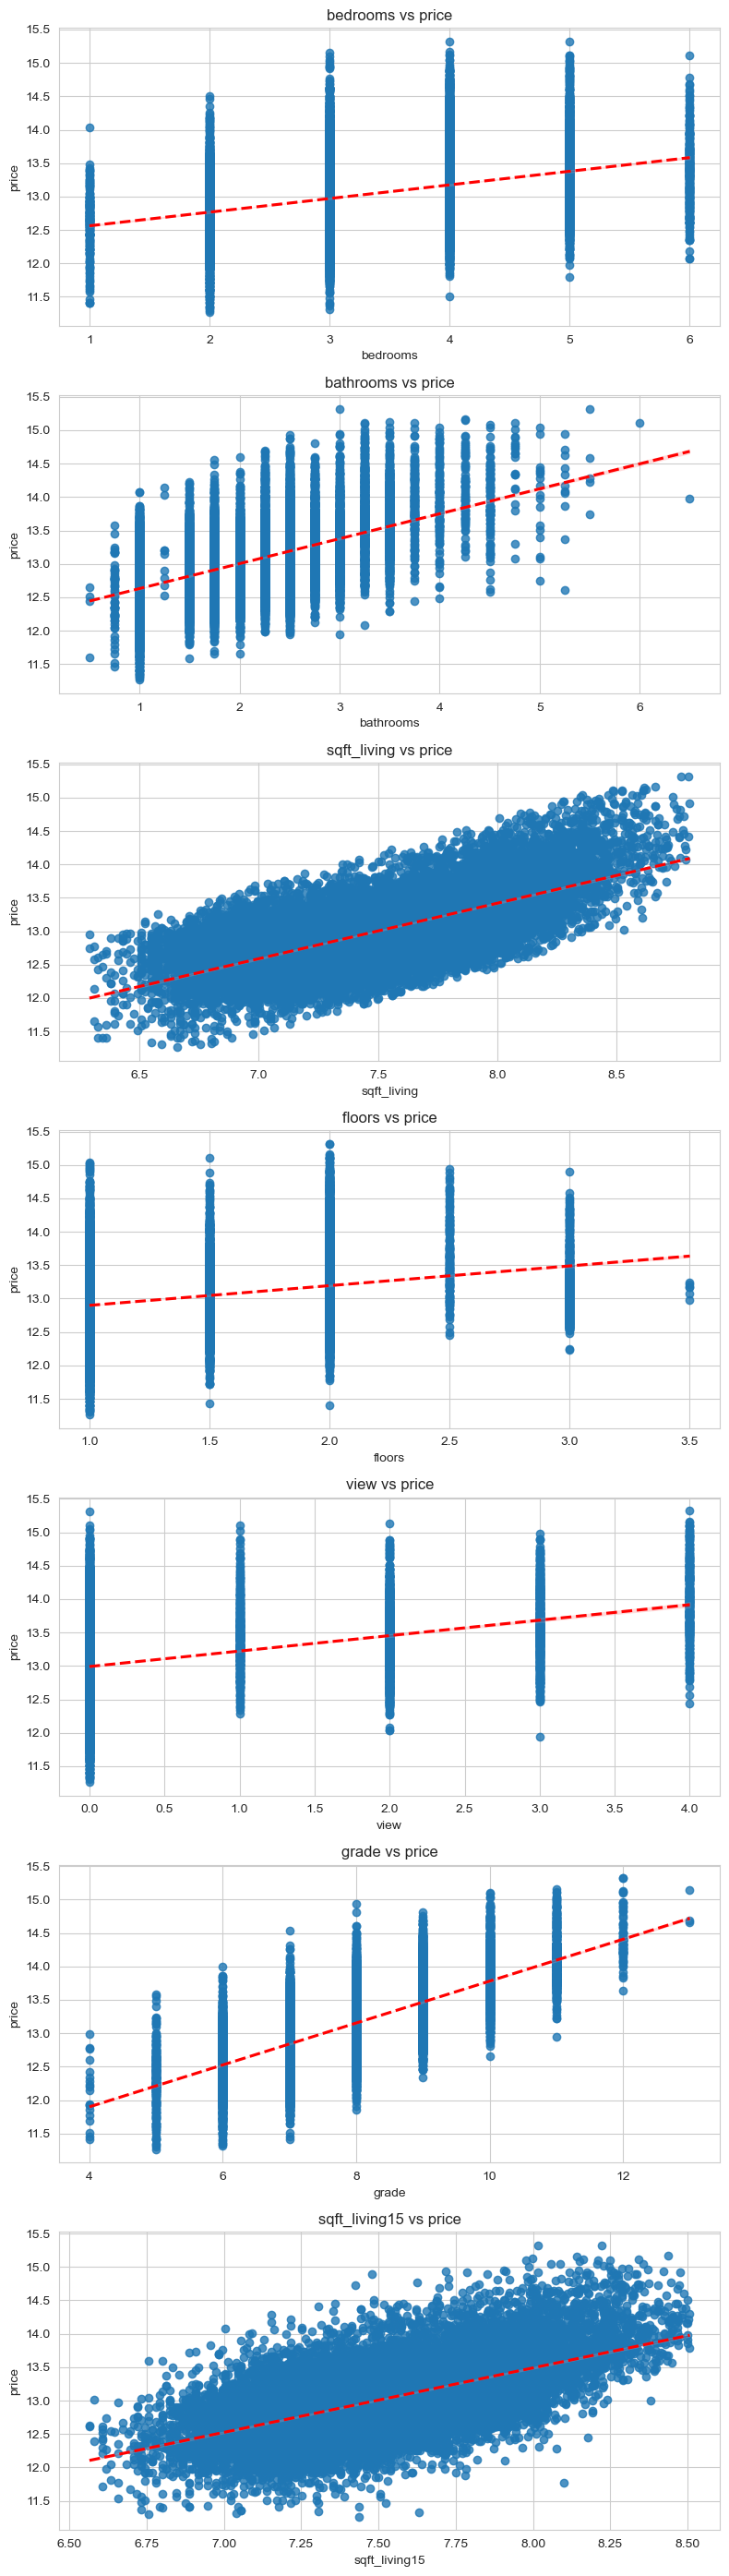

In [21]:
#For loop that just generates graphs for the previous results
#in order to eyeball the trend lines

sns.set_style('whitegrid')

fig, axes = plt.subplots(nrows=len(predictors), figsize=(8, 4*len(predictors)))

for i, col in enumerate(predictors["Features"]):
    sns.regplot(data=house_filtered, x=col, y=outcome, ax=axes[i], line_kws={'color': 'red', 'linestyle': '--'})
    axes[i].set_title(f'{col} vs {outcome}')

plt.tight_layout()
plt.show()

Feature: bedrooms
Polynomial Regression (Degree 1): RMSE = 0.49, R^2 = 0.12
Polynomial Regression (Degree 2): RMSE = 0.49, R^2 = 0.12
Polynomial Regression (Degree 3): RMSE = 0.49, R^2 = 0.12


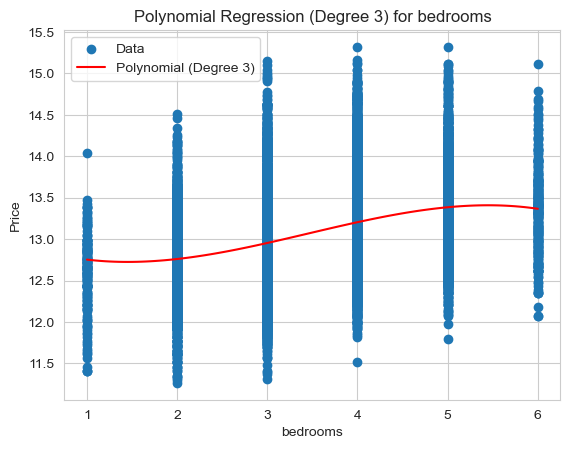

Feature: bathrooms
Polynomial Regression (Degree 1): RMSE = 0.44, R^2 = 0.29
Polynomial Regression (Degree 2): RMSE = 0.44, R^2 = 0.29
Polynomial Regression (Degree 3): RMSE = 0.44, R^2 = 0.30


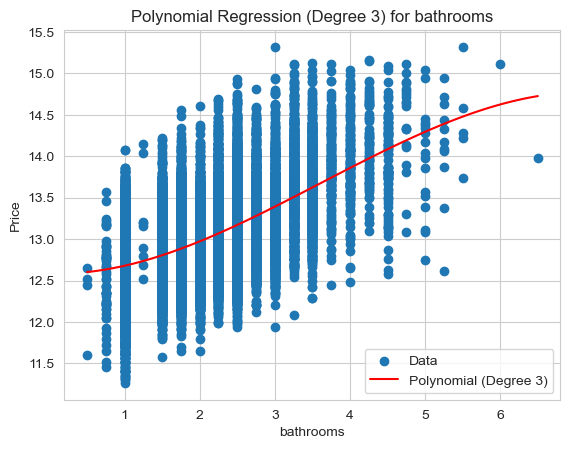

Feature: sqft_living
Polynomial Regression (Degree 1): RMSE = 0.39, R^2 = 0.44
Polynomial Regression (Degree 2): RMSE = 0.38, R^2 = 0.47
Polynomial Regression (Degree 3): RMSE = 0.38, R^2 = 0.47


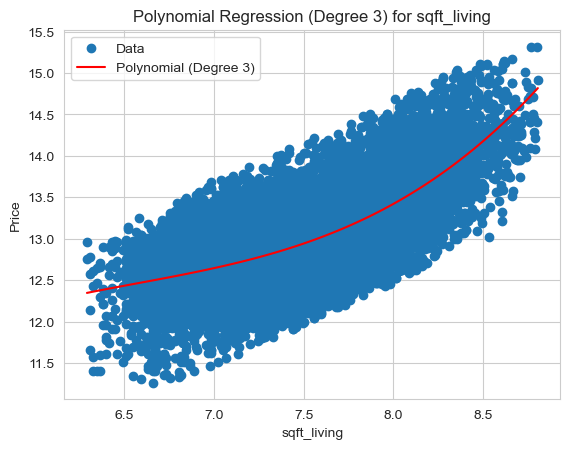

Feature: floors
Polynomial Regression (Degree 1): RMSE = 0.49, R^2 = 0.09
Polynomial Regression (Degree 2): RMSE = 0.49, R^2 = 0.11
Polynomial Regression (Degree 3): RMSE = 0.49, R^2 = 0.11


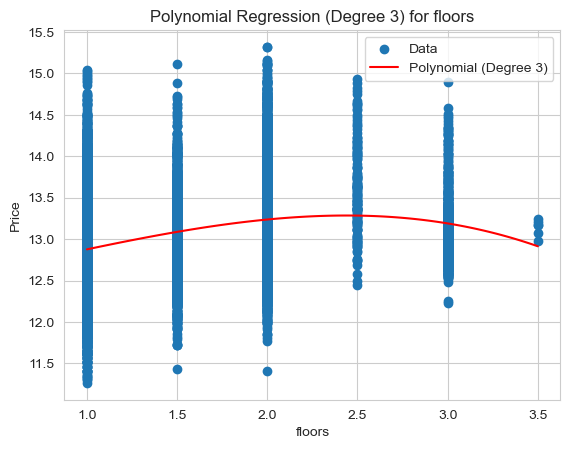

Feature: view
Polynomial Regression (Degree 1): RMSE = 0.49, R^2 = 0.11
Polynomial Regression (Degree 2): RMSE = 0.49, R^2 = 0.11
Polynomial Regression (Degree 3): RMSE = 0.49, R^2 = 0.12


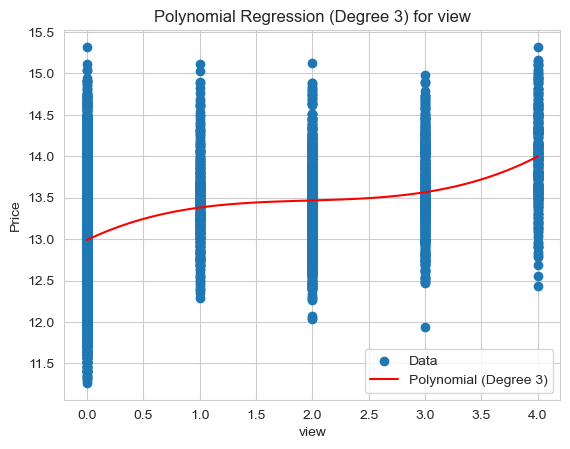

Feature: grade
Polynomial Regression (Degree 1): RMSE = 0.37, R^2 = 0.48
Polynomial Regression (Degree 2): RMSE = 0.37, R^2 = 0.49
Polynomial Regression (Degree 3): RMSE = 0.37, R^2 = 0.49


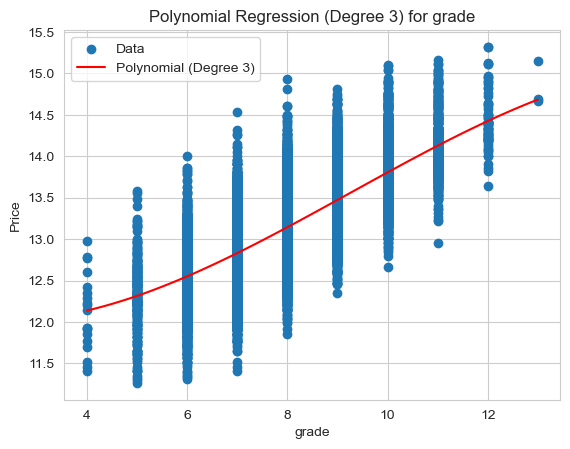

Feature: sqft_living15
Polynomial Regression (Degree 1): RMSE = 0.41, R^2 = 0.36
Polynomial Regression (Degree 2): RMSE = 0.41, R^2 = 0.37
Polynomial Regression (Degree 3): RMSE = 0.41, R^2 = 0.38


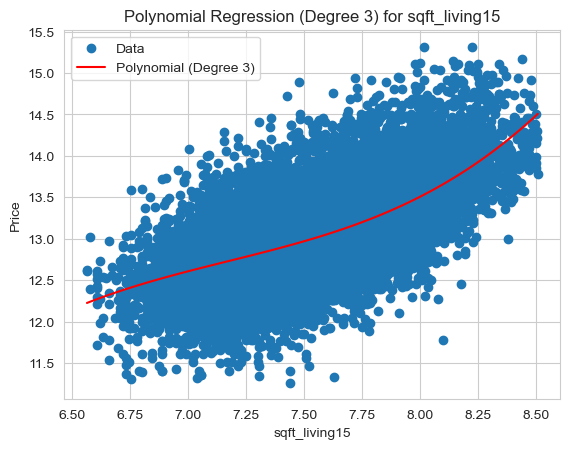

In [22]:
#This gigantic waste of space accomplishes nothing and is irrelevant
#It runs a for loop and takes each predictor through a cross validation for three degrees of polynomial regression
#Then generates a graph for the degree with the lowest rmse score.
#However, the end result was that there's barely any difference in the rmse and r^2 scores
#So it's better to stick to the linear regression above
#The only reason I waded through this mess in the first place was because I forgot to do the log transformation
#And I was confused why my results were wonky
#And when I went back and fixed that this entire section became completley irrevelant
#Since by doing the log tranformation I eliminated the entire need to do the polynomial tranformation down here anyway
#The only reason I left it in is because it still technically calculates the RMSE and r^2 value for the linear
#regression too and at this point I don't feel like doing the objectively easier way because I have this gigantic
#piece of code and I refuse to delete it so I might as well get some use out of it


# Define the maximum degree of polynomial to use
max_degree = 3

# Define the number of cross-validation folds
n_folds = 5

# Loop over each feature and perform polynomial regression up to max_degree
for feature in predictors["Features"]:
    # Split the data into features (X) and target (y)
    X = house_filtered[feature].values.reshape(-1, 1)
    y = house_filtered['price'].values.reshape(-1, 1)

    # Define the k-fold cross-validation generator
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    # Define lists to store the RMSE and R^2 scores for each model
    rmse_list = []
    r2_list = []

    # Loop over each degree and fit the models
    for degree in range(1, max_degree+1):
        # Define the polynomial features and fit the model
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(X)

        # Define lists to store the predictions and actual values
        y_pred_list = []
        y_true_list = []

        # Loop over each fold and fit the models
        for train_index, test_index in kf.split(X):
            X_train, X_test = X_poly[train_index], X_poly[test_index]
            y_train, y_test = y[train_index], y[test_index]

            poly_reg = LinearRegression()
            poly_reg.fit(X_train, y_train)

            y_pred = poly_reg.predict(X_test)
            y_pred_list.append(y_pred)
            y_true_list.append(y_test)

        # Calculate the RMSE and R^2 scores
        y_pred_all = np.concatenate(y_pred_list)
        y_true_all = np.concatenate(y_true_list)
        rmse = np.sqrt(mean_squared_error(y_true_all, y_pred_all))
        r2 = r2_score(y_true_all, y_pred_all)

        rmse_list.append(rmse)
        r2_list.append(r2)

    # Print the results
    print("Feature:", feature)
    for degree in range(1, max_degree+1):
        print("Polynomial Regression (Degree {}): RMSE = {:.2f}, R^2 = {:.2f}".format(degree, rmse_list[degree-1], r2_list[degree-1]))

    # Find the degree of polynomial with the lowest RMSE
    best_degree = np.argmin(rmse_list) + 1

    # Plot the predicted values against the feature for the best degree
    poly = PolynomialFeatures(degree=best_degree)
    X_poly = poly.fit_transform(X)

    poly_reg = LinearRegression()
    poly_reg.fit(X_poly, y)

    X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    X_range_poly = poly.transform(X_range)

    y_pred = poly_reg.predict(X_range_poly)

    plt.figure()
    plt.scatter(X, y, label='Data')
    plt.plot(X_range, y_pred, color='red', label='Polynomial (Degree {})'.format(best_degree))
    plt.xlabel(feature)
    plt.ylabel('Price')
    plt.title('Polynomial Regression (Degree {}) for {}'.format(best_degree, feature))
    plt.legend()
    plt.show()

In [25]:
#Calculating MSE for the model, using cross validation

# Create arrays for the independent variables
X = np.array([house_filtered['sqft_living'], house_filtered['view'], house_filtered['grade'], house_filtered['sqft_living15']]).T

# Create an array for the dependent variable and reset the index
y = house_filtered['price'].reset_index(drop=True)

# Set up cross-validation with 10 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create an array to store the mean squared errors
mse_values = []

# Loop over each fold
for train_index, test_index in kf.split(X):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the linear regression model to the training data for this fold
    model = LinearRegression().fit(X_train, y_train)

    # Calculate the predicted values of the dependent variable for the test data
    y_pred = model.predict(X_test)

    # Calculate the mean squared error for this fold and store it in the mse_values array
    mse_values.append(mean_squared_error(y_test, y_pred))

# Calculate the average mean squared error over all the folds
mse = np.mean(mse_values)

print("Average MSE:", mse)

Average MSE: 0.11774370180782634
